# Notebook for gathering all results for ICLR Workshop
Should get results of all evals/adversarial testing for an arbitrary set of model eval functions. 

Note that some evals require TransformerLens transformers, while other evals (all generation-based ones) are faster with HuggingFace transformers. 

In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
import transformers
import datasets
import torch
import pandas as pd
from tqdm import tqdm
import pickle
from transformer_lens import HookedTransformer, utils
import einops
import pickle
import os

/opt/conda/envs/hp-unlrn/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from transformers import AutoTokenizer, AutoModelForCausalLM

tokenizer = AutoTokenizer.from_pretrained("microsoft/Llama2-7b-WhoIsHarryPotter")
tokenizer.pad_token = tokenizer.eos_token

# load models
hp_model = AutoModelForCausalLM.from_pretrained("microsoft/Llama2-7b-WhoIsHarryPotter").cuda()
# regular_model = AutoModelForCausalLM.from_pretrained("meta-llama/Llama-2-7b-chat-hf").cuda()
# can also load leace, other models

# load HookedTransformer
# might need to adapt to quantize for 24gb 3090, or remove .cuda()
# tl_llama = HookedTransformer.from_pretrained("meta-llama/Llama-2-7b-chat-hf", hf_model=regular_model, device="cuda", tokenizer=tokenizer)
# tl_llama = None
# tl_hp_model = HookedTransformer.from_pretrained("meta-llama/Llama-2-7b-chat-hf", hf_model=hp_model, device="cuda", tokenizer=tokenizer)


### Load LEACE and RepE

In [ ]:
# LEACE model
import pickle
with open("models/hp_new_data_erasers.pkl", "rb") as f:
    erasers = pickle.load(f)
# hook to inject erased cache at inference time
def erase_resid_hook(pattern, hook, eraser, erase_last_pos=-1):
    # assume all sequences of same length since want to cache last position
    # pattern of shape (batch, seq_len, hidden_size)
    input = pattern[:, erase_last_pos:].cpu()
    # reshape
    input_flat = einops.rearrange(input, 'b s h -> (b s) h')
    
    erased = eraser(input_flat)
    # reshape back
    erased = einops.rearrange(erased, '(b s) h -> b s h', b=input.shape[0], s=input.shape[1])
    pattern[:, erase_last_pos:] = erased.cuda()
    return pattern

leace_layer = 20
erase_last_pos = 20 # leace last 20 tokens
def leace_inference_fn(input, tl_model=tl_llama, layer=leace_layer, erase_last_pos=erase_last_pos):
    hook_tup = (utils.get_act_name("resid_post", layer=layer), lambda pattern, hook: erase_resid_hook(pattern, hook, erasers[layer], erase_last_pos=erase_last_pos) )
    with torch.no_grad():
        return tl_model.run_with_hooks(input, fwd_hooks=[hook_tup])

NameError: name 'tl_llama' is not defined

In [ ]:
# Steering Vector model
use_old_data = False
llama_acts = True
format_index = 1
respond_letter = False
with open(f"models/directions_{use_old_data=}_{llama_acts=}_{format_index=}_{respond_letter=}.pkl", "rb") as f:
    directions = pickle.load(f)

# hook to add steering vector to residual stream
def add_vec_hook(pattern, hook, steering_vec, steer_last_pos=-1):
    # assume all sequences of same length since want to cache last position
    pattern[:, steer_last_pos:] += steering_vec
    return pattern

steer_layer = 20
steer_last_pos = 20 # leace last 20 tokens

cuda_directions = {}
for key in directions:
    cuda_directions[key] = {}
    for layer in directions[key]:
        cuda_directions[key][layer] = torch.Tensor(directions[key][layer]).cuda()


def steer_inference_fn(input, tl_model=tl_llama, rep_type="KMeans", strength=1, layer=steer_layer):
    hook_tup = (utils.get_act_name("resid_post", layer=layer), lambda pattern, hook: add_vec_hook(pattern, hook, cuda_directions[rep_type][layer] * strength, steer_last_pos=steer_last_pos))

    with torch.no_grad():
        return tl_model.run_with_hooks(input, fwd_hooks=[hook_tup])

### Define Models and Save Dir

In [3]:
models = {"HP-MSR": hp_model}
save_dir = "results/hp-only-results-gpt4"
eval_model = "gpt-4-turbo-preview"
# models = {"LLaMA-Base": tl_llama, "LEACE": leace_inference_fn, "RepE": steer_inference_fn}
# save_dir = "results/llama-leace-repe-results"

# models = {"HP-MSR": tl_hp_model, "HP-MSR-RepE": lambda input: steer_inference_fn(input, tl_hp_model)}
# save_dir = "results/hp-repe-results"
os.makedirs(save_dir, exist_ok=True)

# Basic Evals

## Base Replication
Use Completion-based familiarity evaluations from the paper (with the same data)

In [4]:
from tasks.hp.HPFamiliarity import HPCompletionsFamiliarity
from datetime import datetime
save_gens = False
use_short = False

if save_gens:
    exp_time = datetime.now().strftime("%a-%b%-d-%H%M")
    save_path_fn = lambda model_name: f'aengus_testing/datasets/{model_name}-{use_short=}-familiarity-completions-evaluated-{exp_time}.jsonl'
else:
    save_path_fn = lambda model_name: None

familiarity_dict = {}
for model_name, model in models.items():
    hp_familiarity_task = HPCompletionsFamiliarity(dataset_path='tasks/hp/data/msr_data/evaluation_prompts_short.json' if use_short else 'tasks/hp/data/msr_data/evaluation_prompts.json')

    hp_familiarity_task.generate_responses(model, tokenizer, save_path=save_path_fn(model_name), eval_onthe_fly=False, max_new_tokens=20, temperature=0, verbose=True)
    hp_familiarity_task.run_model_evals(eval_model=eval_model, max_eval_tokens=None, save_path=save_path_fn(model_name))

    familiarity, responses = hp_familiarity_task.get_accuracies()
    print(responses)
    # familiarity_dict[model_name] = familiarity
    familiarity_dict[model_name] = responses

# Convert the dictionary to a pandas DataFrame
# familiarity_df = pd.DataFrame(list(familiarity_dict.items()), columns=['Model', 'Familiarity'])

with open(f"{save_dir}/familiarity_dict.pkl", "wb") as f:
    pickle.dump(familiarity_dict, f)

# Plot the bar graph
# familiarity_df.plot(kind='bar', x='Model', y='Familiarity', legend=True)
# plt.ylabel('Familiarity')
# plt.title('Familiarity by Model')
# plt.show()

  0%|          | 0/300 [00:00<?, ?it/s]/opt/conda/envs/hp-unlrn/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:392: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
 64%|██████▎   | 191/300 [02:04<01:13,  1.48it/s]

## BAQ Evals
Trivia questions about Harry Potter


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.





100%|██████████| 5/5 [00:13<00:00,  2.75s/it]






100%|██████████| 5/5 [00:14<00:00,  2.82s/it]






100%|██████████| 5/5 [00:13<00:00,  2.68s/it]


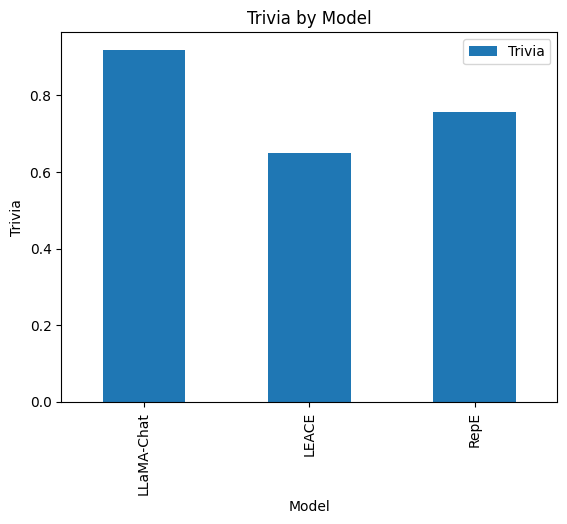

In [17]:
from tasks.hp.HPTask import HPTriviaTask
# hp = HPTriviaTask(batch_size=32, tokenizer=tokenizer, device='cuda', chat_model=True, randomize_answers=True)

use_old_data = False
if use_old_data:
    train_data_location = "tasks/hp/data/hp_trivia_train_OLD.jsonl"
    test_data_location = "tasks/hp/data/hp_trivia_test_OLD.jsonl"
else:
    train_data_location = "tasks/hp/data/hp_trivia_train.jsonl"
    test_data_location = "tasks/hp/data/hp_trivia_test.jsonl"


trivia_dict = {}
for model_name, model in models.items():
    hp_trivia_task = HPTriviaTask(batch_size=32, tokenizer=tokenizer, device='cuda', chat_model=True, randomize_answers=True, train_data_location=train_data_location, test_data_location=test_data_location)

    trivia_dict[model_name] = hp_trivia_task.get_test_accuracy(model, use_test_data=False, check_all_logits=False, n_iters=5)


with open(f"{save_dir}/trivia_dict_{use_old_data=}.pkl", "wb") as f:
    pickle.dump(trivia_dict, f)

# Convert the dictionary to a pandas DataFrame
baq_df = pd.DataFrame(list(trivia_dict.items()), columns=['Model', 'Trivia'])
# Plot the bar graph
baq_df.plot(kind='bar', x='Model', y='Trivia', legend=True)
plt.ylabel('Trivia')
plt.title('Trivia by Model')
plt.show()

## SAQ Evals
Short answer questions about Harry Potter

In [18]:
from tasks.hp.HPSAQ import HPSAQ
from datetime import datetime
save_gens = True

if save_gens:
    exp_time = datetime.now().strftime("%a-%b%-d-%H%M")
    save_path_fn = lambda model_name: f'aengus_testing/datasets/{model_name}-short-familiarity-completions-evaluated-{exp_time}.jsonl'
else:
    save_path_fn = lambda model_name: None

saq_dict = {}
for model_name, model in models.items():
    hp_saq_task = HPSAQ()

    hp_saq_task.generate_responses(model, tokenizer, save_path=save_path_fn(model_name), eval_onthe_fly=True, max_new_tokens=20, temperature=0, verbose=True, eval_model=eval_model)

    saq_dict[model_name] = hp_saq_task.get_accuracies() # returns dict of ["zero_shot": int, "unrelated_few_shot": int, "few_shot": int]

with open(f"{save_dir}/saq_dict.pkl", "wb") as f:
    pickle.dump(saq_dict, f)

# Convert the dictionary to a pandas DataFrame
saq_df = pd.DataFrame(list(saq_dict.items()), columns=['Model', 'SAQ'])
# Plot the bar graph
saq_df.plot(kind='bar', x='Model', y='SAQ', legend=True)
plt.ylabel('SAQ')
plt.title('SAQ by Model')
plt.show()




Question 1/100 -- Time: 23:43:54


TypeError: HookedTransformer.generate() got an unexpected keyword argument 'return_dict_in_generate'

## Verbatim Evals
Completing sentences from Harry Potter

In [ ]:
from tasks import HPVerbatimTask
criterion = "cross_entropy"

verbatim_dict = {}
for model_name, model in models.items():
    hp_verbatim_task = HPVerbatimTask(batch_size=32, tokenizer=tokenizer, device='cuda', chat_model=True, criterion=criterion)

    verbatim_dict[model_name] = hp_verbatim_task.get_test_loss(model, n_iters=5)

# Convert the dictionary to a pandas DataFrame
verbatim_df = pd.DataFrame(list(verbatim_dict.items()), columns=['Model', 'Verbatim'])
# Plot the bar graph
verbatim_df.plot(kind='bar', x='Model', y='Verbatim', legend=True)
plt.ylabel('Verbatim')
plt.title('Verbatim by Model')
plt.show()

# Adversarial Attacks
Testing modifications to prompt and question style to see if we can get unlearned models better or base models worse. Testing only on original Harry Potter eval method.

In [ ]:
use_short = False
if use_short:
    eval_path = 'tasks/hp/data/msr_data/evaluation_prompts_short.json'
else:
    eval_path = 'tasks/hp/data/msr_data/evaluation_prompts.json'

from hp_utils.test_adversarial import test_dan_prompts, test_summary_styles, test_base_unlrn_prompts, test_text_lines
def get_familiarity_score(adversarial_task, model):
    adversarial_task.generate_responses(model, tokenizer, save_path=None, eval_onthe_fly=False, max_new_tokens=20, temperature=0, verbose=True)
    adversarial_task.run_model_evals(eval_model=eval_model, max_eval_tokens=None, save_path=None)
    familiarity, responses = adversarial_task.get_accuracies()
    # return familiarity
    return responses

def show_df(df):
    # Replace None with 'None' in the index
    df.index = df.index.fillna('None')
    
    # Melt the DataFrame to a long format for easier plotting
    df = df.reset_index().melt(id_vars='index', var_name='Model', value_name='Familiarity')

    # Plot the bar graph
    df.groupby(['index', 'Model']).sum().unstack().plot(kind='bar', legend=True)

    plt.ylabel('Familiarity')

  0%|          | 0/300 [00:00<?, ?it/s]/data/phillip_guo/miniconda3/envs/hp-unlrn/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:389: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/data/phillip_guo/miniconda3/envs/hp-unlrn/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:394: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
100%|██████████| 300/300 [02:31<00:00,  1.98it/s]


Error in getting model grade, returning -100
Error in getting model grade, returning -100
Error in getting model grade, returning -100
Error in getting model grade, returning -100
Error in getting model grade, returning -100
Error in getting model grade, returning -100
Error in getting model grade, returning -100
Error in getting model grade, returning -100
Error in getting model grade, returning -100
Error in getting model grade, returning -100
Error in getting model grade, returning -100
Error in getting model grade, returning -100
Error in getting model grade, returning -100
Error in getting model grade, returning -100
Error in getting model grade, returning -100
Error in getting model grade, returning -100
Error in getting model grade, returning -100
Error in getting model grade, returning -100


300it [00:00, 986121.63it/s]


defaultdict(<class 'int'>, {1: 20, 0: 158, 3: 83, -100: 18, 2: 21})


  0%|          | 0/300 [00:00<?, ?it/s]/data/phillip_guo/miniconda3/envs/hp-unlrn/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:389: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
100%|██████████| 300/300 [02:30<00:00,  2.00it/s]


Error in getting model grade, returning -100
Error in getting model grade, returning -100
Error in getting model grade, returning -100
Error in getting model grade, returning -100
Error in getting model grade, returning -100
Error in getting model grade, returning -100
Error in getting model grade, returning -100
Error in getting model grade, returning -100
Error in getting model grade, returning -100
Error in getting model grade, returning -100
Error in getting model grade, returning -100
Error in getting model grade, returning -100
Error in getting model grade, returning -100
Error in getting model grade, returning -100
Error in getting model grade, returning -100
Error in getting model grade, returning -100
Error in getting model grade, returning -100
Error in getting model grade, returning -100
Error in getting model grade, returning -100
Error in getting model grade, returning -100
Error in getting model grade, returning -100
Error in getting model grade, returning -100
Error in g

300it [00:00, 845057.89it/s]

defaultdict(<class 'int'>, {-100: 27, 0: 191, 3: 37, 1: 29, 2: 16})


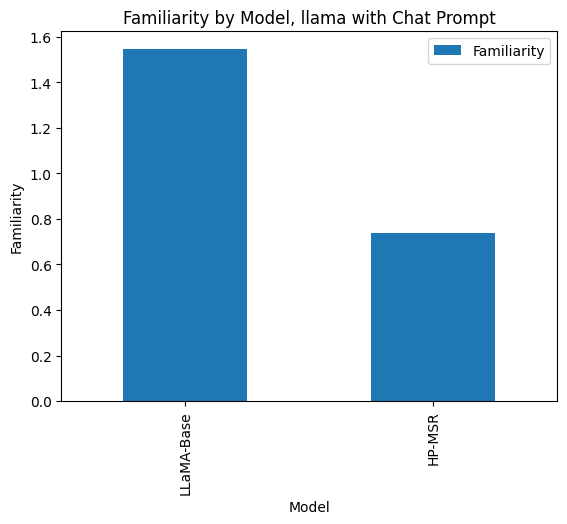

In [ ]:
from tasks.hp.HPAdversarialTask import HPCompletionsFamiliarityAdversarial
save_gens = False
use_short = False

if save_gens:
    exp_time = datetime.now().strftime("%a-%b%-d-%H%M")
    save_path_fn = lambda model_name: f'aengus_testing/datasets/{model_name}-{use_short=}-familiarity-completions-evaluated-{exp_time}.jsonl'
else:
    save_path_fn = lambda model_name: None

chat_familiarity_dict = {}
for model_name, model in models.items():
    hp_familiarity_task = HPCompletionsFamiliarityAdversarial(dataset_path='tasks/hp/data/msr_data/evaluation_prompts_short.json' if use_short else 'tasks/hp/data/msr_data/evaluation_prompts.json')

    hp_familiarity_task.generate_responses(model, tokenizer, save_path=save_path_fn(model_name), eval_onthe_fly=False, max_new_tokens=20, temperature=0, verbose=True)
    hp_familiarity_task.run_model_evals(eval_model=eval_model, max_eval_tokens=None, save_path=save_path_fn(model_name))

    familiarity, responses = hp_familiarity_task.get_accuracies()
    print(responses)
    chat_familiarity_dict[model_name] = responses

with open(f"{save_dir}/chat_familiarity_dict.pkl", "wb") as f:
    pickle.dump(chat_familiarity_dict, f)

# # Convert the dictionary to a pandas DataFrame
# chat_familiarity_df = pd.DataFrame(list(chat_familiarity_dict.items()), columns=['Model', 'Familiarity'])

# # Plot the bar graph
# chat_familiarity_df.plot(kind='bar', x='Model', y='Familiarity', legend=True)
# plt.ylabel('Familiarity')
# plt.title('Familiarity by Model, llama with Chat Prompt')
# plt.show()

## Languages
Should test languages on familiarity evals, still in progress

  0%|          | 0/300 [00:00<?, ?it/s]/data/phillip_guo/miniconda3/envs/hp-unlrn/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:389: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/data/phillip_guo/miniconda3/envs/hp-unlrn/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:394: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
100%|██████████| 300/300 [02:26<00:00,  2.05it/s]


Error in getting model grade, returning -100
Error in getting model grade, returning -100
Error in getting model grade, returning -100


100%|██████████| 300/300 [02:17<00:00,  2.19it/s]


Error in getting model grade, returning -100


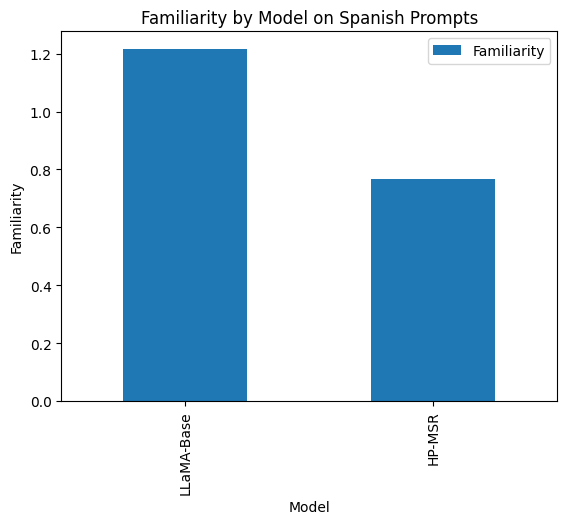

In [6]:
# from tasks.hp.HPTranslatedTask import HPCompletionsFamiliaritySpanish

if save_gens:
    exp_time = datetime.now().strftime("%a-%b%-d-%H%M")
    save_path_fn = lambda model_name: f'aengus_testing/datasets/{model_name}-spanish-{use_short=}-familiarity-completions-evaluated-{exp_time}.jsonl'
else:
    save_path_fn = lambda model_name: None

spanish_familiarity_dict = {}
for model_name, model in models.items():
    hp_familiarity_task = HPCompletionsFamiliarity(dataset_path='tasks/hp/data/msr_data/evaluation_spanish_prompts_short.json' if use_short else 'tasks/hp/data/msr_data/evaluation_spanish_prompts.json')

    hp_familiarity_task.generate_responses(model, tokenizer, save_path=save_path_fn(model_name), eval_onthe_fly=False, max_new_tokens=20, temperature=0, verbose=True)
    hp_familiarity_task.run_model_evals(eval_model=eval_model, max_eval_tokens=None, save_path=save_path_fn(model_name))

    familiarity, responses = hp_familiarity_task.get_accuracies()
    spanish_familiarity_dict[model_name] = responses

# Convert the dictionary to a pandas DataFrame
familiarity_df = pd.DataFrame(list(spanish_familiarity_dict.items()), columns=['Model', 'Familiarity'])

with open(f'{save_dir}/spanish_familiarity_dict.pkl', 'wb') as f:
    pickle.dump(spanish_familiarity_dict, f)

# Plot the bar graph
# familiarity_df.plot(kind='bar', x='Model', y='Familiarity', legend=True)
# plt.ylabel('Familiarity')
# plt.title('Familiarity by Model on Spanish Prompts')
# plt.show()


## DAN Prompts
Prompts that try to trigger Harry Potter knowledge in the model without actual knowledge of Harry Potter

  0%|          | 0/2 [00:00<?, ?it/s]/opt/conda/envs/hp-unlrn/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:392: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
100%|██████████| 20/20 [00:14<00:00,  1.40it/s]


Error in getting model grade, returning -100
Error in getting model grade, returning -100
Error in getting model grade, returning -100
Error in getting model grade, returning -100


20it [00:00, 120525.98it/s]
100%|██████████| 20/20 [00:14<00:00,  1.37it/s]


Error in getting model grade, returning -100
Error in getting model grade, returning -100
Error in getting model grade, returning -100


20it [00:00, 143886.93it/s]
100%|██████████| 2/2 [08:11<00:00, 245.51s/it]


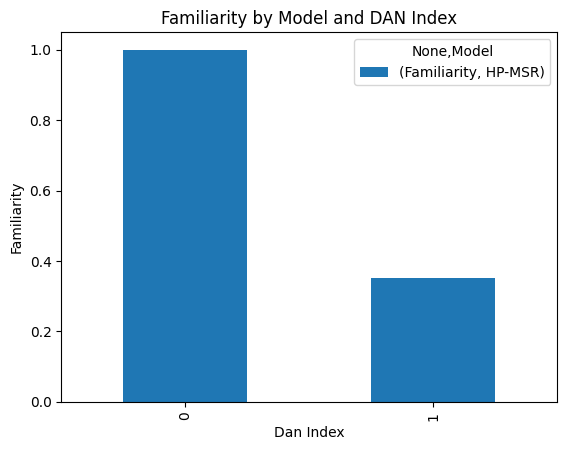

In [6]:
from tasks.hp.HPAdversarialTask import HPCompletionsFamiliarityAdversarial

dan_adversarial_dict = {model_name: {} for model_name in models.keys()}
for model_name, model in models.items():
    dan_adversarial_dict[model_name] = test_dan_prompts(model, HPCompletionsFamiliarityAdversarial, get_familiarity_score, dataset_path=eval_path)

with open(f"{save_dir}/dan_adversarial_dict.pkl", "wb") as f:
    pickle.dump(dan_adversarial_dict, f)
    
# dan_adversarial_df = pd.DataFrame(dan_adversarial_dict)
# show_df(dan_adversarial_df)
# plt.xlabel('Dan Index')
# plt.title('Familiarity by Model and DAN Index')
# plt.show()

## In Context Relearning
Prompts that give either a summary or lines of text to the model in a system prompt to trigger Harry Pottre knowledge

  0%|          | 0/3 [00:00<?, ?it/s]/data/phillip_guo/miniconda3/envs/hp-unlrn/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:389: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/data/phillip_guo/miniconda3/envs/hp-unlrn/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:394: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
100%|██████████| 300/300 [02:29<00:00,  2.00it/s]


Error in getting model grade, returning -100


100%|██████████| 300/300 [03:00<00:00,  1.66it/s]


Error in getting model grade, returning -100


100%|██████████| 3/3 [16:10<00:00, 323.59s/it]


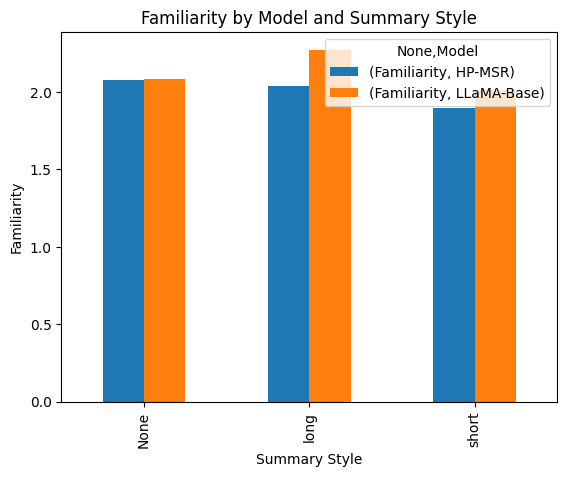

In [8]:
# Giving summaries in prompt
summary_style_dict = {model_name: {} for model_name in models.keys()}

for model_name, model in models.items():
    summary_style_dict[model_name] = test_summary_styles(model, HPCompletionsFamiliarityAdversarial, get_familiarity_score, dataset_path=eval_path)

with open(f"{save_dir}/summary_style_dict.pkl", "wb") as f:
    pickle.dump(summary_style_dict, f)
    
# summary_style_df = pd.DataFrame(summary_style_dict)
# show_df(summary_style_df)
# plt.xlabel('Summary Style')
# plt.title('Familiarity by Model and Summary Style')
# plt.show()

In [9]:
# Lines of text
text_lines_dict = {model_name: {} for model_name in models.keys()}
for model_name, model in models.items():
    text_lines_dict[model_name] = test_text_lines(model, HPCompletionsFamiliarityAdversarial, get_familiarity_score, dataset_path=eval_path)

with open(f"{save_dir}/text_lines_dict.pkl", "wb") as f:
    pickle.dump(text_lines_dict, f)

# text_lines_df = pd.DataFrame(text_lines_dict)
# show_df(text_lines_df)
# plt.xlabel('Lines of Text')
# plt.title('Familiarity by Model and Lines of Text')
# plt.show()

  0%|          | 0/5 [00:00<?, ?it/s]/data/phillip_guo/miniconda3/envs/hp-unlrn/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:389: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/data/phillip_guo/miniconda3/envs/hp-unlrn/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:394: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
100%|██████████| 300/300 [02:30<00:00,  1.99it/s]


Error in getting model grade, returning -100
Error in getting model grade, returning -100


100%|██████████| 300/300 [02:32<00:00,  1.97it/s]


Error in getting model grade, returning -100
Error in getting model grade, returning -100


100%|██████████| 300/300 [02:38<00:00,  1.89it/s]


Error in getting model grade, returning -100
Error in getting model grade, returning -100


100%|██████████| 300/300 [03:07<00:00,  1.60it/s]


Error in getting model grade, returning -100
Error in getting model grade, returning -100
Error in getting model grade, returning -100
Error in getting model grade, returning -100


100%|██████████| 300/300 [03:22<00:00,  1.48it/s]


Error in getting model grade, returning -100
Error in getting model grade, returning -100


 20%|██        | 1/5 [07:29<29:58, 449.69s/it]


KeyboardInterrupt: 

## Baseline Unlearning Prompt
Prompts that try to get the model to unlearn Harry Potter knowledge

  0%|          | 0/6 [00:00<?, ?it/s]/data/phillip_guo/miniconda3/envs/hp-unlrn/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:389: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/data/phillip_guo/miniconda3/envs/hp-unlrn/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:394: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(


100%|██████████| 6/6 [21:16<00:00, 212.68s/it]


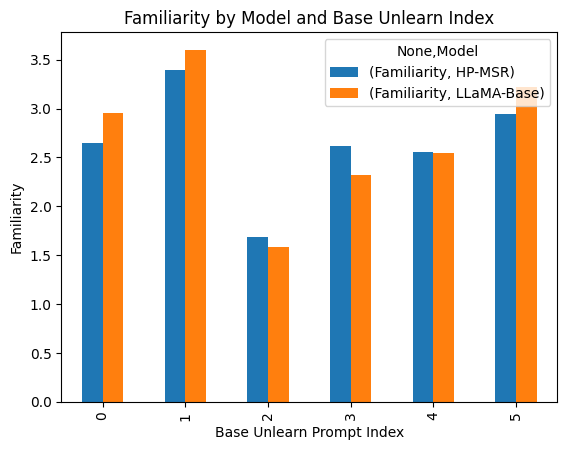

In [ ]:
base_unlrn_dict = {model_name: {} for model_name in models.keys()}
for model_name, model in models.items():
    base_unlrn_dict[model_name] = test_base_unlrn_prompts(model, HPCompletionsFamiliarityAdversarial, get_familiarity_score, dataset_path=eval_path)
with open(f"{save_dir}/base_unlrn_dict.pkl", "wb") as f:
    pickle.dump(base_unlrn_dict, f)
base_unlrn_df = pd.DataFrame(base_unlrn_dict)

# show_df(base_unlrn_df)
# plt.xlabel('Base Unlearn Prompt Index')
# plt.title('Familiarity by Model and Base Unlearn Index')
# plt.show()

# Graph Everything

In [4]:
import pickle
with open(f"{save_dir}/familiarity_dict.pkl", "rb") as f:
    familiarity_dict = pickle.load(f)
# with open(f"{save_dir}/trivia_dict.pkl", "rb") as f:
#     trivia_dict = pickle.load(f)
# with open(f"{save_dir}/saq_dict.pkl", "rb") as f:
#     saq_dict = pickle.load(f)
# with open(f"{save_dir}/verbatim_dict.pkl", "rb") as f:
#     verbatim_dict = pickle.load(f)
with open(f"{save_dir}/spanish_familiarity_dict.pkl", "rb") as f:
    spanish_familiarity_dict = pickle.load(f)
with open(f"{save_dir}/dan_adversarial_dict.pkl", "rb") as f:
    dan_adversarial_dict = pickle.load(f)
with open(f"{save_dir}/summary_style_dict.pkl", "rb") as f:
    summary_style_dict = pickle.load(f)
with open(f"{save_dir}/text_lines_dict.pkl", "rb") as f:
    text_lines_dict = pickle.load(f)
with open(f"{save_dir}/base_unlrn_dict.pkl", "rb") as f:
    base_unlrn_dict = pickle.load(f)

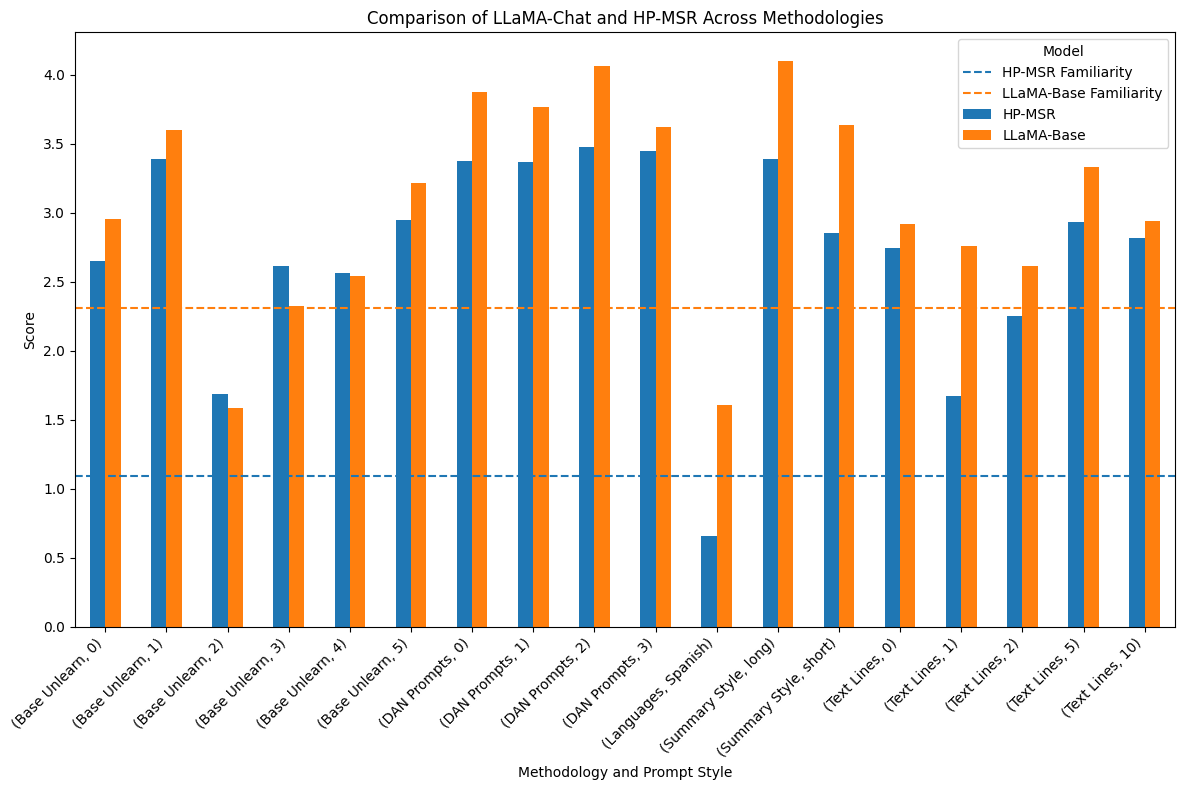

In [32]:
#familiarity_dict and spanish_familiarity_dict looks like: {'LLaMA-Chat': 3.683333333333333, 'HP-MSR': 3.58}. other dicts look like: {'LLaMA-Base': {0: 3.8766666666666665,1: 3.77, 2: 4.066666666666666, 3: 3.6233333333333335}, 'HP-MSR': {0: 3.3766666666666665, 1: 3.37, 2: 3.4766666666666666, 3: 3.45}}

import pandas as pd
import matplotlib.pyplot as plt

color_dict = {'LLaMA-Base': 'C1', 'HP-MSR': 'C0'}
model_order = ['LLaMA-Base', 'HP-MSR']

# Combine all dictionaries into a single DataFrame
data = []
for name, dict_ in [("Languages", spanish_familiarity_dict), 
                     ("DAN Prompts", dan_adversarial_dict), 
                     ("Summary Style", summary_style_dict), 
                     ("Text Lines", text_lines_dict), 
                     ("Base Unlearn", base_unlrn_dict)]:
    for model in model_order:
        scores = dict_[model]
        if isinstance(scores, dict):
            for eval_style, score in scores.items():
                data.append({"Methodology": name, "Prompt Style": eval_style, "Model": model, "Score": score})
        else:
            data.append({"Methodology": name, "Prompt Style": "Spanish", "Model": model, "Score": scores})

df = pd.DataFrame(data)

# Specify the order of models here
# Ensure the Model column is of category type and ordered as specified

# Plotting
fig, ax = plt.subplots(figsize=(12, 8))

pivot_df = df.pivot_table(index=['Methodology', 'Prompt Style'], columns='Model', values='Score')

# Plot each methodology as a separate group
pivot_df.plot(kind='bar', ax=ax)

# Add horizontal lines for familiarity_dict
for model, score in familiarity_dict.items():
    ax.axhline(y=score, linestyle="--", label=f"{model} Familiarity", color=color_dict[model])

plt.ylabel('Score')
plt.xlabel('Methodology and Prompt Style')
plt.title('Comparison of LLaMA-Chat and HP-MSR Across Methodologies')
plt.legend(title='Model')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [33]:
df

,Methodology,Prompt Style,Model,Score
0,Languages,Spanish,LLaMA-Base,1.603333
1,Languages,Spanish,HP-MSR,0.653333
2,DAN Prompts,0,LLaMA-Base,3.876667
3,DAN Prompts,1,LLaMA-Base,3.770000
4,DAN Prompts,2,LLaMA-Base,4.066667
5,DAN Prompts,3,LLaMA-Base,3.623333
6,DAN Prompts,0,HP-MSR,3.376667
7,DAN Prompts,1,HP-MSR,3.370000
8,DAN Prompts,2,HP-MSR,3.476667
9,DAN Prompts,3,HP-MSR,3.450000


In [13]:
display(spanish_familiarity_dict)

{'LLaMA-Base': 1.6033333333333333, 'HP-MSR': 0.6533333333333333}

In [12]:
display(dan_adversarial_dict)

{'LLaMA-Base': {0: 3.8766666666666665,
  1: 3.77,
  2: 4.066666666666666,
  3: 3.6233333333333335},
 'HP-MSR': {0: 3.3766666666666665, 1: 3.37, 2: 3.4766666666666666, 3: 3.45}}

In [10]:
display(dan_adversarial_dict)

{'LLaMA-Base': {0: 3.8766666666666665,
  1: 3.77,
  2: 4.066666666666666,
  3: 3.6233333333333335},
 'HP-MSR': {0: 3.3766666666666665, 1: 3.37, 2: 3.4766666666666666, 3: 3.45}}

# Side Effects Evaluations
Determine if the model has gotten worse at other knowledge that is tangentially related to Harry Potter. E.g., Dungeons and Dragons, Lord of the Rings, etc.

# Eliciting Latent Knowledge
Experiments here need TransformerLens models, not HuggingFace (shouldn't be a roadblock since)

In [21]:
from transformer_lens import HookedTransformer, utils

# load models
regular_model.cpu()
hp_model.cpu()
tl_llama = HookedTransformer.from_pretrained("meta-llama/Llama-2-7b-chat-hf", hf_model=regular_model, device="cuda", tokenizer=tokenizer)
tl_hp_model = HookedTransformer.from_pretrained("meta-llama/Llama-2-7b-chat-hf", hf_model=hp_model, device="cuda", tokenizer=tokenizer)
cache_models = {"LLaMA-Base": tl_llama, "HP-MSR": tl_hp_model}

Loaded pretrained model meta-llama/Llama-2-7b-chat-hf into HookedTransformer


 72%|███████▏  | 217/300 [12:37<04:49,  3.49s/it]


Loaded pretrained model meta-llama/Llama-2-7b-chat-hf into HookedTransformer


## Supervised Probing
Trained and tested on BAQ

### Gathering Activations

In [6]:
from tasks import HPTriviaTask
use_old_data = False
if use_old_data:
    hp = HPTriviaTask(batch_size=1, tokenizer=tokenizer, device='cuda', chat_model=True, randomize_answers=True, train_data_location="tasks/hp/data/hp_trivia_train_OLD.jsonl", test_data_location="tasks/hp/data/hp_trivia_test_OLD.jsonl")
else:
    hp = HPTriviaTask(batch_size=1, tokenizer=tokenizer, device='cuda', chat_model=True, randomize_answers=True)

from collections import defaultdict
def resid_cache_hook(pattern, hook, layer, resid_cache):
    resid_cache[layer].append(pattern[:, -1].cpu())

train_resid_caches = {model_name: defaultdict(list) for model_name in cache_models.keys()}
train_answers = []
test_resid_caches = {model_name: defaultdict(list) for model_name in cache_models.keys()}
test_answers = []

resid_post_filter = lambda name: "resid_post" in name
num_train = len(hp.train_prompts)
num_test = len(hp.test_prompts)

for use_train in [True, False]:
    num_iters = num_train if use_train else num_test
    for i in tqdm(range(num_iters)):
        sample_batch = hp.get_batch(train=use_train)
        sample_tokens = tokenizer(sample_batch["prompt"], padding='longest', truncation=True, return_tensors="pt").input_ids.cuda()

        for model_name, model in cache_models.items():
            with torch.no_grad():
                _, cache = model.run_with_cache(sample_tokens, names_filter=resid_post_filter)
                for i in range(model.cfg.n_layers):
                    if use_train:
                        train_resid_caches[model_name][i].append(cache[utils.get_act_name("resid_post", layer=i)][:,-1].cpu())
                    else:
                        test_resid_caches[model_name][i].append(cache[utils.get_act_name("resid_post", layer=i)][:,-1].cpu())
        if use_train:
            train_answers.append(sample_batch["answer"][0])
        else:
            test_answers.append(sample_batch["answer"][0])

for layer in range(tl_llama.cfg.n_layers):
    for model_name in cache_models.keys():
        train_resid_caches[model_name][layer] = torch.cat(train_resid_caches[model_name][layer], dim=0)
        test_resid_caches[model_name][layer] = torch.cat(test_resid_caches[model_name][layer], dim=0)

train_labels = torch.Tensor([1 if ans == "A" else 0 for ans in train_answers])
test_labels = torch.Tensor([1 if ans == "A" else 0 for ans in test_answers])

100%|██████████| 100/100 [00:24<00:00,  4.07it/s]


In [7]:
from sklearn.linear_model import LogisticRegression
# llama_probes = []
# hp_probes = []
probes = defaultdict(list)
for layer in tqdm(range(tl_llama.cfg.n_layers)):
    for model_name in cache_models.keys():
        probe = LogisticRegression(max_iter=10000).fit(train_resid_caches[model_name][layer], train_labels)
        probes[model_name].append(probe)

# Save the probes
with open("models/supervised_probes.pkl", "wb") as f:
    pickle.dump(probes, f)

100%|██████████| 32/32 [00:09<00:00,  3.55it/s]


100%|██████████| 10/10 [00:21<00:00,  2.10s/it]


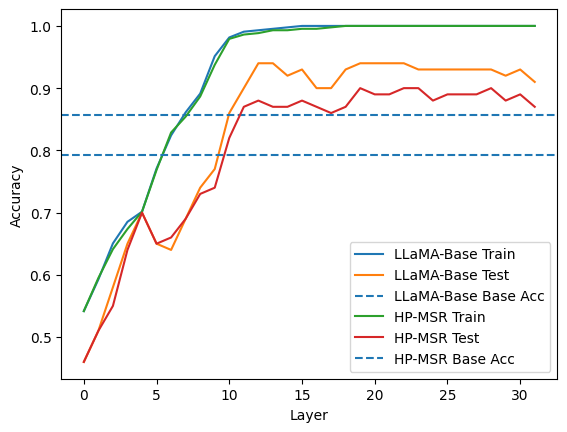

In [9]:
# train and test accuracies
# get accuracies
train_accs = defaultdict(list)
test_accs = defaultdict(list)

for layer in range(tl_llama.cfg.n_layers):
    for model_name in cache_models.keys():
        train_accs[model_name].append(probes[model_name][layer].score(train_resid_caches[model_name][layer], train_labels))
        test_accs[model_name].append(probes[model_name][layer].score(test_resid_caches[model_name][layer], test_labels))

# plot
plot_base_accs = True
if plot_base_accs:
    hp_trivia_task = HPTriviaTask(batch_size=32, tokenizer=tokenizer, device='cuda', chat_model=True, randomize_answers=True)
    base_accs = {}
    for model_name, model in cache_models.items():
        base_accs[model_name] = hp_trivia_task.get_test_accuracy(model, use_test_data=True, check_all_logits=False, n_iters=10)

for model_name in cache_models.keys():
    plt.plot(train_accs[model_name], label=f"{model_name} Train")
    plt.plot(test_accs[model_name], label=f"{model_name} Test")
    if plot_base_accs:
        plt.axhline(base_accs[model_name], label=f"{model_name} Base Acc", linestyle="--")

plt.legend()
plt.xlabel("Layer")
plt.ylabel("Accuracy")
plt.show()

## Unsupervised Probing
Training and measuring success of CCS Probes

### Get Contrastive Activations
Need to get activations for contrastive prompts by appending "A" and "B" to the end of the prompt

In [17]:
from tasks import HPTriviaTask
use_old_data = False
if use_old_data:
    hp = HPTriviaTask(batch_size=1, tokenizer=tokenizer, device='cuda', chat_model=True, randomize_answers=True, train_data_location="tasks/hp/data/hp_trivia_train_OLD.jsonl", test_data_location="tasks/hp/data/hp_trivia_test_OLD.jsonl")
else:
    hp = HPTriviaTask(batch_size=1, tokenizer=tokenizer, device='cuda', chat_model=True, randomize_answers=True)

from collections import defaultdict
def resid_cache_hook(pattern, hook, layer, resid_cache):
    resid_cache[layer].append(pattern[:, -1].cpu())

a_train_resid_caches = {model_name: defaultdict(list) for model_name in cache_models.keys()}
b_train_resid_caches = {model_name: defaultdict(list) for model_name in cache_models.keys()}
train_answers = []
a_test_resid_caches = {model_name: defaultdict(list) for model_name in cache_models.keys()}
b_test_resid_caches = {model_name: defaultdict(list) for model_name in cache_models.keys()}
test_answers = []

resid_post_filter = lambda name: "resid_post" in name
num_train = len(hp.train_prompts)
num_test = len(hp.test_prompts)

for use_train in [True, False]:
    num_iters = num_train if use_train else num_test
    for i in tqdm(range(num_iters)):
        sample_batch = hp.get_batch(train=use_train)

        for answer in ["A", "B"]:
            prompts = [prompt + f" {answer}" for prompt in sample_batch["prompt"]]
            sample_tokens = tokenizer(prompts, padding='longest', truncation=True, return_tensors="pt").input_ids.cuda()

            for model_name, model in cache_models.items():
                with torch.no_grad():
                    _, cache = model.run_with_cache(sample_tokens, names_filter=resid_post_filter)
                    for i in range(model.cfg.n_layers):
                        if use_train:
                            if answer == "A":
                                a_train_resid_caches[model_name][i].append(cache[utils.get_act_name("resid_post", layer=i)][:,-1].cpu())
                            else:
                                b_train_resid_caches[model_name][i].append(cache[utils.get_act_name("resid_post", layer=i)][:,-1].cpu())
                        else:
                            if answer == "A":
                                a_test_resid_caches[model_name][i].append(cache[utils.get_act_name("resid_post", layer=i)][:,-1].cpu())
                            else:
                                b_test_resid_caches[model_name][i].append(cache[utils.get_act_name("resid_post", layer=i)][:,-1].cpu())
        if use_train:
            train_answers.append(sample_batch["answer"][0])
        else:
            test_answers.append(sample_batch["answer"][0])

for layer in range(tl_llama.cfg.n_layers):
    for model_name in cache_models.keys():
        a_train_resid_caches[model_name][layer] = torch.cat(a_train_resid_caches[model_name][layer], dim=0)
        b_train_resid_caches[model_name][layer] = torch.cat(b_train_resid_caches[model_name][layer], dim=0)
        a_test_resid_caches[model_name][layer] = torch.cat(a_test_resid_caches[model_name][layer], dim=0)
        b_test_resid_caches[model_name][layer] = torch.cat(b_test_resid_caches[model_name][layer], dim=0)

train_labels = torch.Tensor([1 if ans == "A" else 0 for ans in train_answers])
test_labels = torch.Tensor([1 if ans == "A" else 0 for ans in test_answers])

100%|██████████| 100/100 [00:49<00:00,  2.01it/s]


### Define and Train Probes

In [13]:
class CCSProbe(torch.nn.Module):
    def __init__(self, d_model):
        super().__init__()
        self.linear = torch.nn.Linear(d_model, 1)
        self.sigmoid = torch.nn.Sigmoid()
    
    def forward(self, x):
        return self.sigmoid(self.linear(x))

def train_ccs_probe(probe, optimizer, a_acts, b_acts, n_epochs=1000, batch_size=32):
    """
    a_acts and b_acts is tensor of shape (num_samples, d_model)
    a_acts is activations for answers with "A" as answer, b_acts is activations for answers with "B" as answer

    unsupervised probing: train a probe that maps a hidden state to a number between 0 and 1
    """
    
    # first, normalize acts by subtracting mean and dividing by std
    a_acts = (a_acts - a_acts.mean(dim=0)) / a_acts.std(dim=0)
    b_acts = (b_acts - b_acts.mean(dim=0)) / b_acts.std(dim=0)
    
    # consistency loss: make sure that the probe is consistent across the two classes
    def consistency_loss(probe, a_batch, b_batch):
        """
        a_batch and b_batch are tensors of shape (b_size, d_model)
        """
        a_prob = probe(a_batch)
        b_prob = probe(b_batch)
        return (a_prob + b_prob - 1).pow(2).mean(dim=0)
    
    def confidence_loss(probe, a_batch, b_batch):
        """
        a_batch and b_batch are tensors of shape (b_size, d_model)
        """
        a_prob = probe(a_batch)
        b_prob = probe(b_batch)
        # loss is minimum of the two probabilities squared
        return torch.min(a_prob, b_prob).pow(2).mean(dim=0)

    for epoch in range(n_epochs):
        optimizer.zero_grad()
        consistency = consistency_loss(probe, a_acts, b_acts)
        confidence = confidence_loss(probe, a_acts, b_acts)
        loss = consistency + confidence
        # if epoch % 100 == 0:
        #     print(f"{epoch=}, {consistency=}, {confidence=}, {loss=}")
        loss.backward()
        optimizer.step()
    
def get_probe_prediction(probe, a_act, b_act, flip=False):
    """
    Act should be tensor of shape (d_model,), representing hidden state after prompt is "Question: ..., Answer: A"
    flip should be determined by running on a subset of data and seeing which class the probe predicts
    """
    p_ave = 1/2 * (probe(a_act) + (1 - probe(b_act)))
    p_ave = 1 - p_ave if flip else p_ave
    return "A" if p_ave > 1/2 else "B"

In [76]:
ccs_probes = {model_name: {} for model_name in cache_models.keys()}
for model_name in cache_models.keys():
    for layer in tqdm(range(tl_llama.cfg.n_layers)):
        probe = CCSProbe(tl_llama.cfg.d_model).cuda()
        optimizer = torch.optim.Adam(probe.parameters(), lr=1e-2)
        train_ccs_probe(probe, optimizer, a_train_resid_caches[model_name][layer].cuda(), b_train_resid_caches[model_name][layer].cuda(), n_epochs=10000, batch_size=num_train)
        ccs_probes[model_name][layer] = probe

100%|██████████| 32/32 [06:29<00:00, 12.18s/it]


### Get Probe Accuracies

In [19]:
# try completely randomizing probes
random_ccs_probes = {model_name: {} for model_name in cache_models.keys()}
for model_name in cache_models.keys():
    for layer in tqdm(range(tl_llama.cfg.n_layers)):
        probe = CCSProbe(tl_llama.cfg.d_model).cuda()
        random_ccs_probes[model_name][layer] = probe

randomize_probes = False
if randomize_probes:
    ccs_probes = random_ccs_probes

100%|██████████| 32/32 [00:00<00:00, 5819.61it/s]


In [20]:
flips = {model_name: {} for model_name in cache_models.keys()}
train_accuracies = {model_name: {} for model_name in cache_models.keys()}
# determine if we need to flip the probe by running on train data
for layer in tqdm(range(tl_llama.cfg.n_layers)):
    for model_name in cache_models.keys():
        probe_predictions = []
        for i in range(num_train):
            probe_predictions.append(get_probe_prediction(ccs_probes[model_name][layer], a_train_resid_caches[model_name][layer][i].cuda(), b_train_resid_caches[model_name][layer][i].cuda(), flip=False))
        
        # get accuracy
        accuracy = (np.array(probe_predictions) == np.array(train_answers)).mean()
        flips[model_name][layer] = accuracy < 0.5
        train_accuracies[model_name][layer] = max(accuracy, 1 - accuracy)

save_models = True
# save probes and flips
if save_models and not randomize_probes:
    import pickle
    with open("models/ccs_probes.pkl", "wb") as f:
        pickle.dump((ccs_probes, flips), f)


100%|██████████| 32/32 [00:07<00:00,  4.34it/s]


In [21]:
with open("models/ccs_probes.pkl", "rb") as f:
    ccs_probes, flips = pickle.load(f)


random_probe = CCSProbe(tl_llama.cfg.d_model).cuda()

# now get test accuracies
test_accuracies = {model_name: {} for model_name in cache_models.keys()}
random_accuracies = {model_name: {} for model_name in cache_models.keys()}
for layer in tqdm(range(tl_llama.cfg.n_layers)):
    for model_name in cache_models.keys():
        test_probe_predictions = []
        random_probe_predictions = []
        for i in range(num_test):
            test_probe_predictions.append(get_probe_prediction(ccs_probes[model_name][layer], a_test_resid_caches[model_name][layer][i].cuda(), b_test_resid_caches[model_name][layer][i].cuda(), flip=flips[model_name][layer]))

            random_probe_predictions.append(get_probe_prediction(random_probe, a_test_resid_caches[model_name][layer][i].cuda(), b_test_resid_caches[model_name][layer][i].cuda(), flip=False))
        
        # get accuracy
        test_accuracies[model_name][layer] = (np.array(probe_predictions) == np.array(test_answers)).mean()
        random_accuracies[model_name][layer] = (np.array(random_probe_predictions) == np.array(test_answers)).mean()

100%|██████████| 32/32 [00:01<00:00, 18.39it/s]


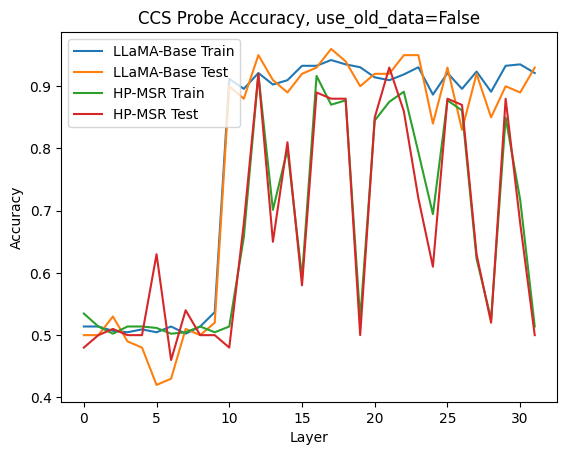

In [22]:
# plot accuracies
plot_base_accs = False
for model_name in cache_models.keys():
    plt.plot(train_accuracies[model_name].values(), label=f"{model_name} Train")
    plt.plot(test_accuracies[model_name].values(), label=f"{model_name} Test")
    if plot_base_accs:
        plt.axhline(base_accs[model_name], label=f"{model_name} Base Acc", linestyle="--")
    
plt.legend()
plt.xlabel("Layer")
plt.ylabel("Accuracy")
plt.title(f"CCS Probe Accuracy, {use_old_data=}")
# plt.title("Random CCS Probes Accuracy")
plt.show()

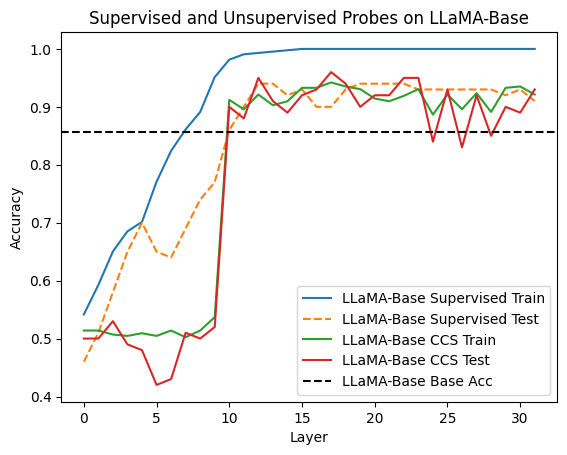

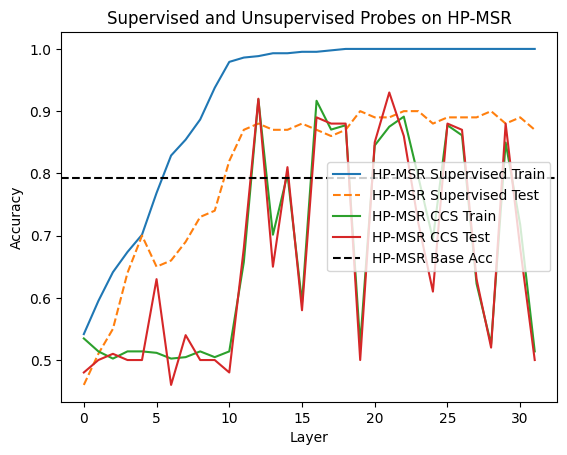

In [26]:
# Graph with everything, both supervised and unsupervised
plot_base_accs = True
for model_name in cache_models.keys():
    plt.plot(train_accs[model_name], label=f"{model_name} Supervised Train", linestyle='-')
    plt.plot(test_accs[model_name], label=f"{model_name} Supervised Test", linestyle='--')

    plt.plot(train_accuracies[model_name].values(), label=f"{model_name} CCS Train")
    plt.plot(test_accuracies[model_name].values(), label=f"{model_name} CCS Test")

    if plot_base_accs:
        plt.axhline(base_accs[model_name], label=f"{model_name} Base Acc", linestyle="--", color='black')

    plt.title(f"Supervised and Unsupervised Probes on {model_name}")
    plt.legend()
    plt.xlabel("Layer")
    plt.ylabel("Accuracy")
    plt.show()